In [154]:
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import IPython.display as ipd
from playsound import playsound
import os
from constants import *
from functions import *
# from audio_class import Audio
import music21
import matplotlib.collections as collections
from matplotlib.widgets import Slider

In [155]:
directory = os.getcwd()
# audio_name = '\Audio\piano\A blues scale with breaks.wav'
# audio_name = '\Audio\piano\A blues scale.wav'
# audio_name = '\Audio\C ionian scale.wav'
# audio_name = '\Audio\\piano single notes\piano A4.wav'
audio_name = '\Audio\Recorded\output.wav'
# audio_name = '\Audio\sax\single notes\sax F#2.wav'
# audio_name = '\Audio\sax\\autumn leaves high(150 bpm).wav'
# audio_name = '\Audio\sax\\C ionian scale sax.wav'
# audio_name = '\Audio\sax\\F# blues scale sax.wav'
# audio_name = '\Audio\sax\\melody d ionian 120 bpm.wav'
# audio_name = '\Audio\sax\\single notes\\sax F#1.wav'


audio_path = directory + audio_name
audio_path = audio_path
y, sr = librosa.load(audio_path, SAMPLE_RATE)

C:\Users\Krzysiek\AppData\Local\Temp\ipykernel_34192\1106416019.py:17: FutureWarning: Pass sr=44100 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  y, sr = librosa.load(audio_path, SAMPLE_RATE)


In [156]:
top_db = 30
y_2 = np.zeros(y.shape[0])
y_splitted = librosa.effects.split(y, top_db=top_db)
print(y_splitted)
for sound in y_splitted:
    start_idx = sound[0]
    end_idx = sound[1]
    y_2[start_idx:end_idx] = y[start_idx:end_idx]

# fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(10,8))
# librosa.display.waveshow(y, ax=ax[0], sr=sr, label='original audio')
# ax[0].legend()
# librosa.display.waveshow(y_2, ax=ax[1], sr=sr, label=f'Audio with threshold={top_db}')
# ax[1].legend()
# plt.show()

[[ 24576 206848]]


In [157]:
# o_env = librosa.onset.onset_strength(y, sr=sr, aggregate=np.median)

real_onsets_times = [0.5, 0.832, 1.02, 1.326, 1.508, 1.787, 2.0, 2.284, 2.77, 3.287, 3.745, 4.0, 4.282, 4.464, 4.793,
                     5.32, 5.77, 6.0,
                     6.28, 6.46, 6.77, 7.268, 7.768, 7.955, 8.131, 8.278, 8.5, 8.8, 8.96, 9.29]
real_onsets_frames = librosa.time_to_frames(real_onsets_times, sr=sr)
#
o_env = librosa.onset.onset_strength(y_2, sr=sr, aggregate=np.median)
# o_env = librosa.onset.onset_strength(y, sr=sr, aggregate=np.median, fmax=8000, n_mels=256)
print(len(o_env))

times = librosa.times_like(o_env, sr=sr)
onset_frames = librosa.onset.onset_detect(onset_envelope=o_env, sr=sr)
onset_frames = list(onset_frames)
times_of_onsets = librosa.frames_to_time(onset_frames, sr=sr)


# print(real_onsets_times)
# print(f"real_onsets_frames: (len: {len(real_onsets_frames)})\n", real_onsets_frames)


def filter_onset(onset_frames):
    print(f"Detected onset frames: (len: {len(onset_frames)})\n", onset_frames)
    onset_frames = np.array(onset_frames)
    distance_list = []
    amplitudes = o_env[onset_frames]
    deleted_frames = []
    for i in range(len(onset_frames) - 1):
        distance = onset_frames[i + 1] - onset_frames[i]
        distance_list.append(distance)
    len_of_onset_frames = len(onset_frames) - 1
    for i in range(len_of_onset_frames):
        if distance_list[i] < 10:
            if amplitudes[i + 1] > amplitudes[i]:
                deleted_frames.append(onset_frames[i])
            else:
                deleted_frames.append(onset_frames[i + 1])
    print(deleted_frames)
    new_onsets = np.setdiff1d(onset_frames, deleted_frames)
    removed_indexes = []
    for i in range(1, len(new_onsets) - 2):
        if o_env[new_onsets[i]] < np.mean(o_env[new_onsets[i-1:i+2]]) / 2:
            removed_indexes.append(i)
    # print(f"New onset frames: (len: {len(new_onsets)})\n", new_onsets)
    # print(f"mean_removed: (len: {len(removed_indexes)})\n", removed_indexes)

    return new_onsets, deleted_frames, removed_indexes


new_onsets, deleted_frames, removed = filter_onset(onset_frames)
new_onsets = np.array(new_onsets)
new_amplitudes = o_env[new_onsets]
final_onsets = np.delete(new_onsets, removed)
print(f"Final frames: (len: {len(final_onsets)})\n", final_onsets)

431
Detected onset frames: (len: 19)
 [50, 65, 80, 95, 109, 124, 139, 154, 170, 184, 199, 243, 260, 275, 308, 322, 338, 358, 378]
[]
Final frames: (len: 18)
 [ 50  65  80 109 124 139 154 170 184 199 243 260 275 308 322 338 358 378]


C:\Users\Krzysiek\AppData\Local\Temp\ipykernel_34192\3566216922.py:8: FutureWarning: Pass y=[0. 0. 0. ... 0. 0. 0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  o_env = librosa.onset.onset_strength(y_2, sr=sr, aggregate=np.median)


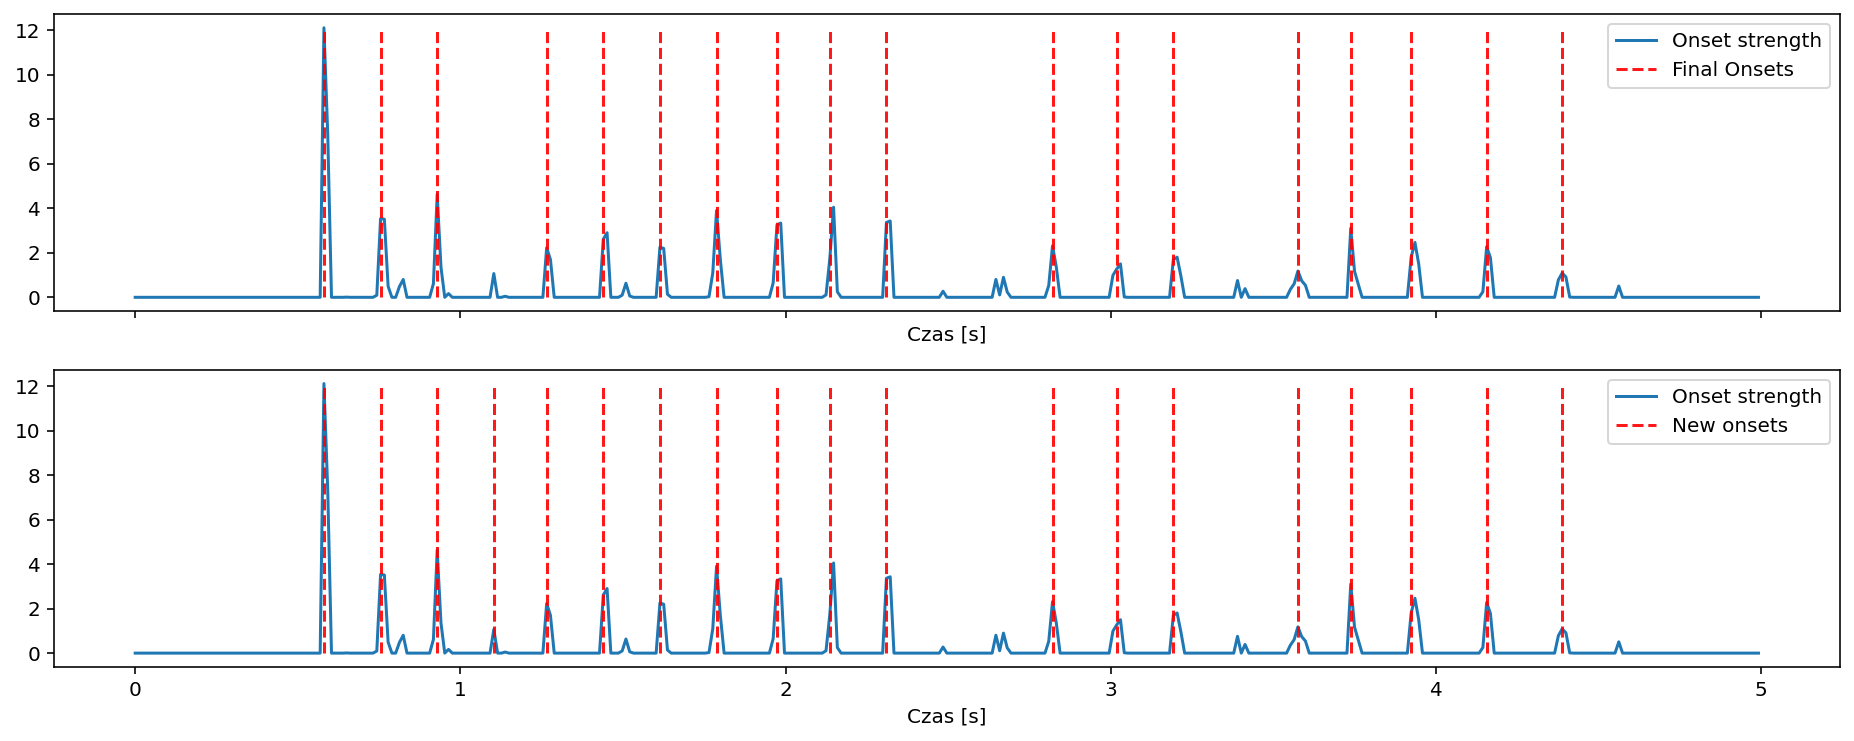

In [158]:
D = np.abs(librosa.stft(y))
fig, ax = plt.subplots(nrows=2, figsize=(16, 6), sharex=True)

ax[0].plot(times, o_env, label='Onset strength')
# ax[0].vlines(times[onset_frames], 0, o_env.max(), color='r', alpha=0.9, linestyle='--', label='Onsets')
ax[0].vlines(times[final_onsets], 0, o_env.max(), color='r', alpha=0.9, linestyle='--', label='Final Onsets')

# ax[0].vlines(times[real_onsets_frames], 0, o_env.max(), color='k', alpha=0.9, linestyle='--', label='Real Onsets')
ax[0].legend()
ax[0].set_xlabel("Czas [s]")

ax[1].plot(times, o_env, label='Onset strength')
ax[1].vlines(times[new_onsets], 0, o_env.max(), color='r', alpha=0.9, linestyle='--', label='New onsets')
# ax[1].vlines(times[real_onsets_frames], 0, o_env.max(), color='k', alpha=0.9, linestyle='--', label='Real onsets')
ax[1].legend()
ax[1].set_xlabel("Czas [s]")

plt.show()

In [159]:
clicks = librosa.clicks(frames=onset_frames, sr=sr, length=len(y))
ipd.Audio(y + clicks, rate=sr)

In [160]:
clicks = librosa.clicks(frames=new_onsets, sr=sr, length=len(y))
ipd.Audio(y + clicks, rate=sr)

In [161]:
clicks = librosa.clicks(frames=final_onsets, sr=sr, length=len(y))
ipd.Audio(y + clicks, rate=sr)

In [162]:
# D = np.abs(librosa.stft(y))
# fig, ax = plt.subplots(nrows=2, figsize=(10,8), sharex=True)
# librosa.display.specshow(librosa.amplitude_to_db(D, ref=np.max),
#                          x_axis='time', y_axis='log', ax=ax[0], sr=SAMPLE_RATE)
# ax[0].set(title=f'Power spectrogram of {audio_name}')
# ax[0].label_outer()
# ax[1].plot(times, o_env, label='Onset strength')
# ax[1].vlines(times[onset_frames], 0, o_env.max(), color='r', alpha=0.9,
#              linestyle='--', label='Onsets')
# ax[1].legend()
# ax[1].set_xlabel("Czas [s]")

In [163]:
# f0, voiced_flag, voiced_probs = librosa.pyin(y,
#                                              sr=sr,
#                                              fmin=librosa.note_to_hz('C2'),
#                                              fmax=librosa.note_to_hz('C7'),
#                                              fill_na=None)
#
# # To synthesize the f0, we'll need sample times
#
# times = librosa.times_like(f0, sr=sr)

In [164]:
# # We'll need IPython.display's Audio widget
# print(f0.shape)
# print(voiced_flag.shape)
# print(times.shape)
# print(voiced_flag)
#
# from IPython.display import Audio
#
# # We'll also use `mir_eval` to synthesize a signal for us
# import mir_eval.sonify
#
# vneg = (-1)**(~voiced_flag)
#
# # And sonify the f0 using mir_eval
# y_f0 = mir_eval.sonify.pitch_contour(times, f0 * vneg, sr)
# print(f0)
# Audio(data=y_f0, rate=sr)

In [165]:
# D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
# fig, ax = plt.subplots()
# img = librosa.display.specshow(D, x_axis='time', y_axis='log', ax=ax, sr=sr)
# ax.set(title='pYIN fundamental frequency estimation')
# fig.colorbar(img, ax=ax, format="%+2.f dB")
# ax.plot(times, f0, label='f0', color='cyan', linewidth=3)
# ax.legend(loc='upper right')
# plt.show()